# **Exercício Prático 03 - Árvore de Decisão e Tuning**
## Aprendizado de Máquina A
### **Professor(es):** Gisele Lobo Pappa e Lourenço Ribeiro Grossi Araújo
### **Aluno:** Bernardo Reis de Almeida

#### **Imports**

In [1]:
import time
import optuna
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from optuna.samplers import TPESampler
from sklearn.tree import DecisionTreeClassifier

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

/home/bereis01/Personal/UFMG/Projects/MLA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### **Árvore de Classificação 2D - Impureza, Ganho de Informação e Fronteiras**

##### Preparação

In [2]:
# Reading all the data from csv
df = pd.read_csv("dados/secao1.csv")

##### Tarefas A e B

In [3]:
class Node:
    def __init__(
        self,
        data: pd.DataFrame,
        depth: int = 0,
        space_min: dict = {"x1": 0, "x2": 0},
        space_max: dict = {"x1": 1, "x2": 1},
    ):
        # Shared attributes
        self.type = "Leaf"
        self.depth = depth

        # Leaf node attributes
        self.data = data
        self.label = data["y"].mode()[0]

        # Inner node attributes
        self.split = None
        self.left = None
        self.right = None
        self.min = space_min
        self.max = space_max

        # The gini value of the node is kept
        # even if it becomes an inner node
        self.gini = (
            1
            - (pow((sum(self.data["y"] == 0) / self.data.shape[0]), 2))
            - (pow((sum(self.data["y"] == 1) / self.data.shape[0]), 2))
        )


class Tree:
    def __init__(
        self,
        max_depth: int = 100,
        n_min: int = 20,
        min_gain: float = 0.0,
        verbose: bool = False,
    ):
        self.root = None
        self.max_depth = max_depth
        self.n_min = n_min
        self.min_gain = min_gain
        self.verbose = verbose

    def _split_node(self, node: Node):
        # Does nothing if stopping conditions are met
        if node.depth >= self.max_depth:  # Max depth
            return
        if (sum(node.data["y"]) == 0) or (
            sum(node.data["y"]) == node.data.shape[0]
        ):  # Node purity
            return

        # Finds the best attribute and split point
        _gain = -1
        _split = None
        _attribute = None
        for attribute in node.data.columns[:-2]:

            # Sorts data by the attribute and extract its values
            node.data.sort_values(attribute, inplace=True)
            values = node.data[attribute].to_numpy()

            # Tries all splitting possibilites
            for i in range(node.data.shape[0] - 1):

                # Executes the split
                split = (values[i + 1] + values[i]) / 2
                left = node.data[node.data[attribute] <= split]
                right = node.data[node.data[attribute] > split]

                # Calculates its gain
                gini_left = (
                    1
                    - (pow((sum(left["y"] == 0) / left.shape[0]), 2))
                    - (pow((sum(left["y"] == 1) / left.shape[0]), 2))
                )
                gini_right = (
                    1
                    - (pow((sum(right["y"] == 0) / right.shape[0]), 2))
                    - (pow((sum(right["y"] == 1) / right.shape[0]), 2))
                )
                gain = node.gini - (
                    (left.shape[0] / node.data.shape[0]) * gini_left
                    + (right.shape[0] / node.data.shape[0]) * gini_right
                )

                # Selects it if it is better
                if gain > _gain:
                    _gain = gain
                    _split = split
                    _attribute = attribute

        # Does nothing if stopping conditions are met, part 2
        if (node.data[node.data[_attribute] <= _split].shape[0] < self.n_min) or (
            node.data[node.data[_attribute] > _split].shape[0] < self.n_min
        ):  # Min num of instances per node
            return
        if _gain < self.min_gain:  # Min gain
            return

        # Splits on the best point
        node.split = (_attribute, _split)
        node.left = Node(
            node.data[node.data[_attribute] <= _split].copy(),
            node.depth + 1,
            node.min.copy(),
            node.max.copy(),
        )
        node.right = Node(
            node.data[node.data[_attribute] > _split].copy(),
            node.depth + 1,
            node.min.copy(),
            node.max.copy(),
        )

        # Updates the subspaces corresponding to each new node
        node.left.max[_attribute] = _split
        node.right.min[_attribute] = _split

        # Displays the split
        if self.verbose:
            print(f"Split on Depth {node.depth}")
            print(f"  - Attribute: {_attribute}")
            print(f"  - Split Point: {_split}")
            print(f"  - Gain: {_gain}")
            split_df = {
                "Left": [sum(node.left.data["y"] == 0), sum(node.left.data["y"] == 1)],
                "Right": [
                    sum(node.right.data["y"] == 0),
                    sum(node.right.data["y"] == 1),
                ],
            }
            split_df = pd.DataFrame.from_dict(split_df, orient="index")
            display(split_df)

        # Updates the current node to inner node
        node.type = "Inner"
        node.data = None

        # Continues the splitting on the children
        self._split_node(node.left)
        self._split_node(node.right)

    def fit(self, data):
        if self.root == None:
            self.root = Node(data)
        self._split_node(self.root)

    def predict(self, data):
        result = []

        # Evaluates each instance in data
        for i in range(data.shape[0]):
            x = data.iloc[i]

            # Traverses the tree, looking for the leaf to which x belongs
            curr_node = self.root
            while True:
                if curr_node.type == "Leaf":
                    result.append(curr_node.label)
                    break
                else:
                    attribute, split = curr_node.split
                    if x[attribute] <= split:
                        curr_node = curr_node.left
                    else:
                        curr_node = curr_node.right

        return result

In [4]:
tree = Tree(max_depth=3, n_min=10, min_gain=0, verbose=True)
tree.fit(df)

Split on Depth 0
  - Attribute: x1
  - Split Point: 0.6228255986438233
  - Gain: 0.1195081265801421


,0,1
Left,248,59
Right,59,134


Split on Depth 1
  - Attribute: x2
  - Split Point: 0.7032499906264459
  - Gain: 0.1184334519074349


,0,1
Left,210,8
Right,38,51


Split on Depth 2
  - Attribute: x1
  - Split Point: 0.3473952942372732
  - Gain: 0.36378862005336765


,0,1
Left,3,48
Right,35,3


Split on Depth 1
  - Attribute: x2
  - Split Point: 0.30868901708949575
  - Gain: 0.3940872953430582


,0,1
Left,56,0
Right,3,134


Split on Depth 2
  - Attribute: x1
  - Split Point: 0.789379278961855
  - Gain: 0.0013871657672606327


,0,1
Left,3,53
Right,0,81


##### Tarefa C

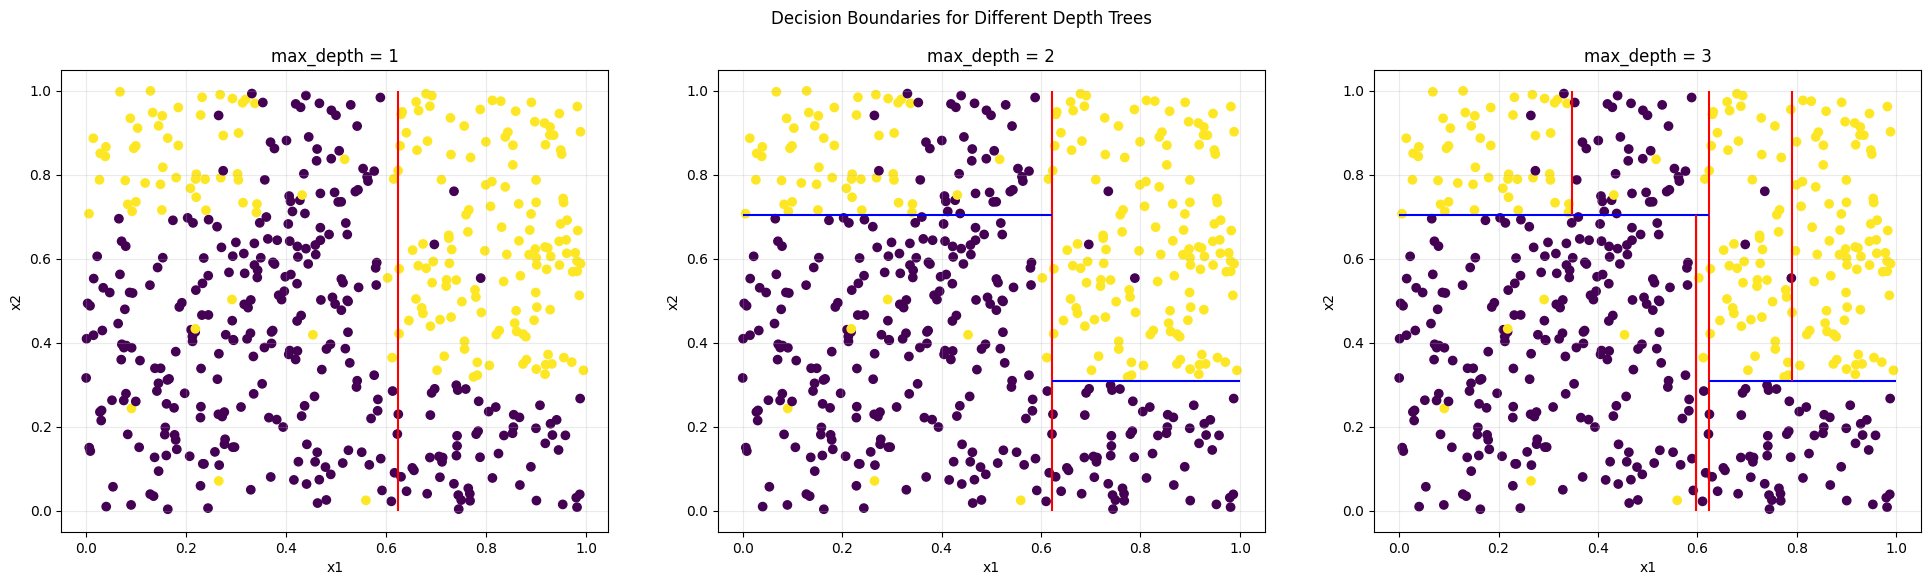

In [5]:
def plot_split(node: Node, ax):
    if node.type == "Leaf":
        return
    else:
        attribute, split = node.split
        if attribute == "x1":
            ax.vlines(split, node.min["x2"], node.max["x2"], color="red")
        else:
            ax.hlines(split, node.min["x1"], node.max["x1"], color="blue")
        plot_split(node.left, ax)
        plot_split(node.right, ax)


# Configures the image
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle("Decision Boundaries for Different Depth Trees")

# Plots the database
for i in range(3):
    ax[i].scatter(df["x1"], df["x2"], c=df["y"])

# Trains various trees on different max_depths
max_depths = [1, 2, 3]
for i in range(3):
    tree = Tree(max_depth=max_depths[i], n_min=0, min_gain=0)
    tree.fit(df)

    # Traverses the tree, plotting the split points
    plot_split(tree.root, ax[i])

    # Configures the ax
    ax[i].set_title(f"max_depth = {max_depths[i]}")
    ax[i].set_xlabel("x1")
    ax[i].set_ylabel("x2")
    ax[i].grid(alpha=0.25)

# Shows the resulting plot
plt.show()
plt.close()

##### Tarefa D

In [6]:
# Shuffles the dataset
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Stratified train/test separation
label_0 = df[df["y"] == 0].copy()
label_1 = df[df["y"] == 1].copy()

label_0_split = int(0.7 * label_0.shape[0])
label_1_split = int(0.7 * label_1.shape[0])

train = pd.concat(
    [label_0.iloc[:label_0_split], label_1.iloc[:label_1_split]]
).reset_index(drop=True)
test = pd.concat(
    [label_0.iloc[label_0_split:], label_1.iloc[label_1_split:]]
).reset_index(drop=True)

# Trains tree in train set
tree = Tree(max_depth=3, n_min=10, min_gain=0)
tree.fit(train)

# Reports test accuracy
predictions = tree.predict(test)
print("Test Acc:", sum(predictions == test["y"]) / test.shape[0])

# Reports confusion matrix
predictions = pd.Series(predictions)

true_0 = test["y"] == 0
true_1 = test["y"] == 1

true_negative = sum(predictions[true_0] == 0)
false_negative = sum(predictions[true_1] == 0)

true_positive = sum(predictions[true_1] == 1)
false_positive = sum(predictions[true_0] == 1)

confusion_matrix = {
    "Predicted 0": [true_negative, false_negative, true_negative + false_negative],
    "Predicted 1": [false_positive, true_positive, false_positive + true_positive],
    "Total": [
        true_negative + false_positive,
        false_negative + true_positive,
        true_negative + false_negative + false_positive + true_positive,
    ],
}
confusion_matrix = pd.DataFrame.from_dict(
    confusion_matrix, orient="index", columns=["True 0", "True 1", "Total"]
)
display(confusion_matrix)

Test Acc: 0.9735099337748344


,True 0,True 1,Total
Predicted 0,91,2,93
Predicted 1,2,56,58
Total,93,58,151


##### Tarefa E

*Feito à mão e anexado ao .pdf*

#### **Tuning de Hiperparâmetros - Grade, Aleatória e Bayesiana**

##### Preparação

In [7]:
# Reading all the data from csv
df = pd.read_csv("dados/dados_tuning.csv")

Os espaços de busca escolhidos para os hiperparâmetros foram os seguintes:
- max_depth ∈ {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
- n_min ∈ {5, 10, 15, 20, 25, 30, 35, 40, 45, 50}
- min_gain ∈ [0, 0.01] (contínuo; 10 valores igualmente espaçados foram escolhidos no caso da busca em grid)

In [8]:
# Hiperparameters
max_depths = range(1, 11)  # max_depth is in {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
n_mins = list(range(0, 51, 5))[
    1:
]  # n_min is in {5, 10, 15, 20, 25, 30, 35, 40, 45, 50}
min_gains = (0, 0.01, 10)  # min_gain is in [0, 0.01] (continuous)

n_folds = 4

In [9]:
# Stratified train/test separation
label_0 = df[df["y"] == 0].copy()
label_1 = df[df["y"] == 1].copy()

label_0_split = int(0.7 * label_0.shape[0])
label_1_split = int(0.7 * label_1.shape[0])

train = pd.concat(
    [label_0.iloc[:label_0_split], label_1.iloc[:label_1_split]]
).reset_index(drop=True)
test = pd.concat(
    [label_0.iloc[label_0_split:], label_1.iloc[label_1_split:]]
).reset_index(drop=True)

# Fold split index
fold_size = int(train.shape[0] / n_folds)

# Shuffles the train set for K-fold
train = train.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Converts everything to numpy arrays
X_train = train[["x1", "x2", "x3", "x4", "x5"]].to_numpy(copy=True)
y_train = train["y"].to_numpy(copy=True)

X_test = test[["x1", "x2", "x3", "x4", "x5"]].to_numpy(copy=True)
y_test = test["y"].to_numpy(copy=True)

##### Tuning

In [10]:
# Logging
print("#### GRID SEARCH ####")
print()

# Grid search
grid = itertools.product(
    max_depths, n_mins, np.linspace(min_gains[0], min_gains[1], min_gains[2])
)

# Stores best values
_acc = 0
_max_depth, _n_min, _min_gain = None, None, None

# Logging
print("==== OPTIMIZATION TRACE ====")
start_time = time.time()

# Optimization stack
grid_stack = pd.DataFrame(columns=["max_depth", "n_min", "min_gain", "acc", "var_acc"])

for max_depth, n_min, min_gain in grid:
    # Metrics
    val_acc = []

    for i in range(n_folds):
        # Generates the fold
        X_train_fold = np.concat(
            [X_train[: (i * fold_size)], X_train[((i + 1) * fold_size) :]]
        )
        y_train_fold = np.concat(
            [y_train[: (i * fold_size)], y_train[((i + 1) * fold_size) :]]
        )
        X_val_fold = X_train[(i * fold_size) : ((i + 1) * fold_size)]
        y_val_fold = y_train[(i * fold_size) : ((i + 1) * fold_size)]

        # Fits the model
        tree = DecisionTreeClassifier(
            criterion="gini",
            random_state=RANDOM_STATE,
            max_depth=max_depth,
            min_samples_leaf=n_min,
            min_impurity_decrease=min_gain,
        )
        tree.fit(X_train_fold, y_train_fold)

        # Calculates fold validation acc
        predictions = tree.predict(X_val_fold)
        val_acc.append(sum(predictions == y_val_fold) / y_val_fold.shape[0])

    # Reports validation accuracy
    avg_val_acc = np.mean(val_acc)
    var_val_acc = np.sum(np.pow(val_acc - avg_val_acc, 2))
    print(
        "Param.:", (max_depth, n_min, str(min_gain)[:4]), "   Val. Acc.:", avg_val_acc
    )

    # Updates stack
    grid_stack.loc[-1] = [
        int(max_depth),
        int(n_min),
        float(min_gain),
        float(avg_val_acc),
        float(var_val_acc),
    ]
    grid_stack.index = grid_stack.index + 1

    # Updates best parameters if acc is better
    if avg_val_acc > _acc:
        _acc = avg_val_acc
        _max_depth, _n_min, _min_gain = max_depth, n_min, min_gain

# Saving best
grid_best = (_max_depth, _n_min, _min_gain)

# Logging
end_time = time.time()
print()
print("==== BEST VALUES ====")
print("- accuracy:", _acc)
print("- max_depth:", _max_depth)
print("- n_min:", _n_min)
print("- min_gain:", _min_gain)

print()
print("==== COMPUTATIONAL COST ====")
print("- N° of Iterations:", len(max_depths) * len(n_mins) * min_gains[2] * n_folds)
print("- Time Elapsed (sec):", end_time - start_time)

#### GRID SEARCH ####

==== OPTIMIZATION TRACE ====
Param.: (1, 5, '0.0')    Val. Acc.: 0.6259541984732824
Param.: (1, 5, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 5, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 5, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 5, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 5, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 5, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 5, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 5, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 5, '0.01')    Val. Acc.: 0.6259541984732824
Param.: (1, 10, '0.0')    Val. Acc.: 0.6259541984732824
Param.: (1, 10, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 10, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 10, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 10, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 10, '0.00')    Val. Acc.: 0.6259541984732824
Param.: (1, 10, '0.00')    Val. Acc.: 0.62595419

In [11]:
# Logging
print("#### RANDOM SEARCH ####")
print()

# Random search
N = len(max_depths) * len(n_mins) * min_gains[2]

# Stores best values
_acc = 0
_max_depth, _n_min, _min_gain = None, None, None
_best_index = 0

# Logging
print("==== OPTIMIZATION TRACE ====")
start_time = time.time()

# Graphs
acc_evol_random = []

# Optimization stack
random_stack = pd.DataFrame(columns=["max_depth", "n_min", "min_gain", "acc", "var_acc"])

for j in range(N):
    # Samples hiperparameters
    max_depth = np.random.choice(max_depths)
    n_min = np.random.choice(n_mins)
    min_gain = np.random.uniform(min_gains[0], min_gains[1])

    # Metrics
    val_acc = []

    for i in range(n_folds):
        # Generates the fold
        X_train_fold = np.concat(
            [X_train[: (i * fold_size)], X_train[((i + 1) * fold_size) :]]
        )
        y_train_fold = np.concat(
            [y_train[: (i * fold_size)], y_train[((i + 1) * fold_size) :]]
        )
        X_val_fold = X_train[(i * fold_size) : ((i + 1) * fold_size)]
        y_val_fold = y_train[(i * fold_size) : ((i + 1) * fold_size)]

        # Fits the model
        tree = DecisionTreeClassifier(
            criterion="gini",
            random_state=RANDOM_STATE,
            max_depth=max_depth,
            min_samples_leaf=n_min,
            min_impurity_decrease=min_gain,
        )
        tree.fit(X_train_fold, y_train_fold)

        # Calculates fold validation acc
        predictions = tree.predict(X_val_fold)
        val_acc.append(sum(predictions == y_val_fold) / y_val_fold.shape[0])

    # Reports validation accuracy
    avg_val_acc = np.mean(val_acc)
    var_val_acc = np.sum(np.pow(val_acc - avg_val_acc, 2))
    print(
        "Param.:", (max_depth, n_min, str(min_gain)[:4]), "   Val. Acc.:", avg_val_acc
    )

    # Updates stack
    random_stack.loc[-1] = [
        int(max_depth),
        int(n_min),
        float(min_gain),
        float(avg_val_acc),
        float(var_val_acc),
    ]
    random_stack.index = random_stack.index + 1

    # Updates best parameters if acc is better
    if avg_val_acc > _acc:
        _acc = avg_val_acc
        _max_depth, _n_min, _min_gain = max_depth, n_min, min_gain
        _best_index = j

    # Graphs
    acc_evol_random.append(_acc)

# Saving best
random_best = (_max_depth, _n_min, _min_gain)

# Logging
end_time = time.time()
print()
print("==== BEST VALUES ====")
print("- accuracy:", _acc)
print("- max_depth:", _max_depth)
print("- n_min:", _n_min)
print("- min_gain:", _min_gain)

print()
print("==== COMPUTATIONAL COST ====")
print("- N° of Iterations:", len(max_depths) * len(n_mins) * min_gains[2] * n_folds)
print("- Time Elapsed (sec):", end_time - start_time)

#### RANDOM SEARCH ####

==== OPTIMIZATION TRACE ====
Param.: (np.int64(7), np.int64(20), '0.00')    Val. Acc.: 0.6259541984732824
Param.: (np.int64(8), np.int64(25), '0.00')    Val. Acc.: 0.8683206106870229
Param.: (np.int64(3), np.int64(35), '0.00')    Val. Acc.: 0.6183206106870228
Param.: (np.int64(8), np.int64(25), '0.00')    Val. Acc.: 0.6889312977099237
Param.: (np.int64(8), np.int64(15), '0.00')    Val. Acc.: 0.8893129770992367
Param.: (np.int64(2), np.int64(40), '0.00')    Val. Acc.: 0.6259541984732824
Param.: (np.int64(6), np.int64(10), '0.00')    Val. Acc.: 0.8034351145038169
Param.: (np.int64(5), np.int64(5), '0.00')    Val. Acc.: 0.7223282442748091
Param.: (np.int64(6), np.int64(45), '0.00')    Val. Acc.: 0.8120229007633587
Param.: (np.int64(10), np.int64(15), '0.00')    Val. Acc.: 0.7471374045801527
Param.: (np.int64(4), np.int64(45), '0.00')    Val. Acc.: 0.7089694656488549
Param.: (np.int64(3), np.int64(35), '0.00')    Val. Acc.: 0.6183206106870228
Param.: (np.int64(7), 

In [12]:
# Logging
print("#### BAYESIAN SEARCH ####")
print()

# Bayesian search
N = len(max_depths) * len(n_mins) * min_gains[2]

# Stores best values
_acc = 0
_max_depth, _n_min, _min_gain = None, None, None

# Logging
print("==== OPTIMIZATION TRACE ====")
start_time = time.time()

# Optimization stack
bayes_stack = pd.DataFrame(columns=["max_depth", "n_min", "min_gain", "acc", "var_acc"])

# Search config
def objective(trial):
    # Samples hiperparameters
    max_depth = trial.suggest_categorical("max_depth", max_depths)
    n_min = trial.suggest_categorical("n_min", max_depths)
    min_gain = trial.suggest_float("min_gain", min_gains[0], min_gains[1])

    # Metrics
    val_acc = []

    for i in range(n_folds):
        # Generates the fold
        X_train_fold = np.concat(
            [X_train[: (i * fold_size)], X_train[((i + 1) * fold_size) :]]
        )
        y_train_fold = np.concat(
            [y_train[: (i * fold_size)], y_train[((i + 1) * fold_size) :]]
        )
        X_val_fold = X_train[(i * fold_size) : ((i + 1) * fold_size)]
        y_val_fold = y_train[(i * fold_size) : ((i + 1) * fold_size)]

        # Fits the model
        tree = DecisionTreeClassifier(
            criterion="gini",
            random_state=RANDOM_STATE,
            max_depth=max_depth,
            min_samples_leaf=n_min,
            min_impurity_decrease=min_gain,
        )
        tree.fit(X_train_fold, y_train_fold)

        # Calculates fold validation acc
        predictions = tree.predict(X_val_fold)
        val_acc.append(sum(predictions == y_val_fold) / y_val_fold.shape[0])

    # Reports validation accuracy
    avg_val_acc = np.mean(val_acc)
    var_val_acc = np.sum(np.pow(val_acc - avg_val_acc, 2))

    # Updates stack
    bayes_stack.loc[-1] = [
        int(max_depth),
        int(n_min),
        float(min_gain),
        float(avg_val_acc),
        float(var_val_acc),
    ]
    bayes_stack.index = bayes_stack.index + 1
    
    return avg_val_acc


# Optimizes the hyperparameters
study = optuna.create_study(
    study_name="Bayesian Optimizer", sampler=TPESampler(), direction="maximize"
)
study.optimize(objective, n_trials=N)

# Best values
_acc = study.best_trial.value
_max_depth = study.best_trial.params["max_depth"]
_n_min = study.best_trial.params["n_min"]
_min_gain = study.best_trial.params["min_gain"]

# Saving best
bayes_best = (_max_depth, _n_min, _min_gain)

# Graphs
acc = 0
acc_evol_bayes = []
for trial in study.get_trials():
    if trial.value > acc:
        acc = trial.value
    acc_evol_bayes.append(acc)

# Logging
end_time = time.time()
print()
print("==== BEST VALUES ====")
print("- accuracy:", _acc)
print("- max_depth:", _max_depth)
print("- n_min:", _n_min)
print("- min_gain:", _min_gain)

print()
print("==== COMPUTATIONAL COST ====")
print("- N° of Iterations:", len(max_depths) * len(n_mins) * min_gains[2] * n_folds)
print("- Time Elapsed (sec):", end_time - start_time)

[I 2025-10-10 17:41:15,086] A new study created in memory with name: Bayesian Optimizer
[I 2025-10-10 17:41:15,096] Trial 0 finished with value: 0.6259541984732824 and parameters: {'max_depth': 9, 'n_min': 3, 'min_gain': 0.007770948697851934}. Best is trial 0 with value: 0.6259541984732824.
[I 2025-10-10 17:41:15,102] Trial 1 finished with value: 0.6259541984732824 and parameters: {'max_depth': 1, 'n_min': 10, 'min_gain': 0.0034326810931188867}. Best is trial 0 with value: 0.6259541984732824.


#### BAYESIAN SEARCH ####

==== OPTIMIZATION TRACE ====


[I 2025-10-10 17:41:15,110] Trial 2 finished with value: 0.6259541984732824 and parameters: {'max_depth': 3, 'n_min': 1, 'min_gain': 0.00991236502467979}. Best is trial 0 with value: 0.6259541984732824.
[I 2025-10-10 17:41:15,119] Trial 3 finished with value: 0.6908396946564885 and parameters: {'max_depth': 8, 'n_min': 10, 'min_gain': 0.005425526326919504}. Best is trial 3 with value: 0.6908396946564885.
[I 2025-10-10 17:41:15,126] Trial 4 finished with value: 0.6259541984732824 and parameters: {'max_depth': 2, 'n_min': 5, 'min_gain': 0.009298865657345808}. Best is trial 3 with value: 0.6908396946564885.
[I 2025-10-10 17:41:15,133] Trial 5 finished with value: 0.6259541984732824 and parameters: {'max_depth': 2, 'n_min': 9, 'min_gain': 0.005610406241856289}. Best is trial 3 with value: 0.6908396946564885.
[I 2025-10-10 17:41:15,143] Trial 6 finished with value: 0.6937022900763359 and parameters: {'max_depth': 10, 'n_min': 7, 'min_gain': 0.005342685161693956}. Best is trial 6 with value:


==== BEST VALUES ====
- accuracy: 0.9045801526717557
- max_depth: 10
- n_min: 2
- min_gain: 0.0019342033740184432

==== COMPUTATIONAL COST ====
- N° of Iterations: 4000
- Time Elapsed (sec): 20.248489379882812


##### Análise

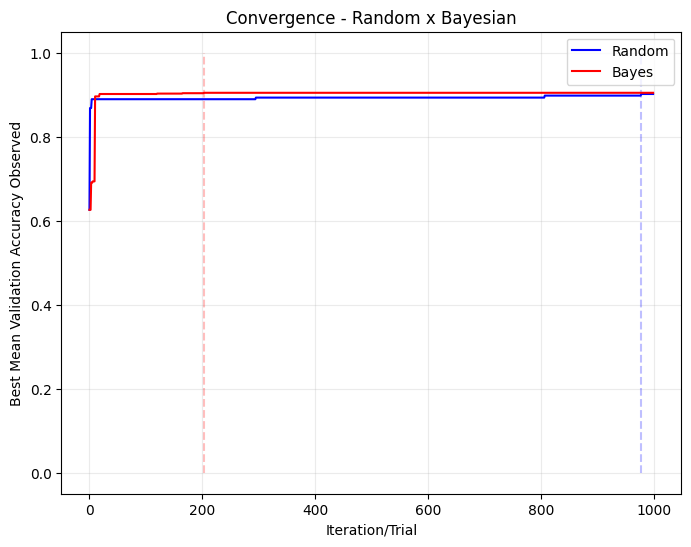

In [13]:
# Plots convergence graph comparing random and bayesian
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

# Plotting the data
ax.plot(range(N), acc_evol_random, label="Random", color="blue")
# ax.scatter(range(N), acc_evol_random, color="blue")
ax.vlines(_best_index, ymin=0, ymax=1, color="blue", linestyles="dashed", alpha=0.25)

ax.plot(range(N), acc_evol_bayes, label="Bayes", color="red")
# ax.scatter(range(N), acc_evol_bayes, color="red")
ax.vlines(
    study.best_trial.number,
    ymin=0,
    ymax=1,
    color="red",
    linestyles="dashed",
    alpha=0.25,
)

# Formatting
ax.grid(alpha=0.25)
ax.legend()
ax.set_title("Convergence - Random x Bayesian")
ax.set_xlabel("Iteration/Trial")
ax.set_ylabel("Best Mean Validation Accuracy Observed")

# Displaying image
plt.show()
plt.close()

*No gráfico acima, a linha pontilhada indica a iteração em que o valor ótimo é encontrado.

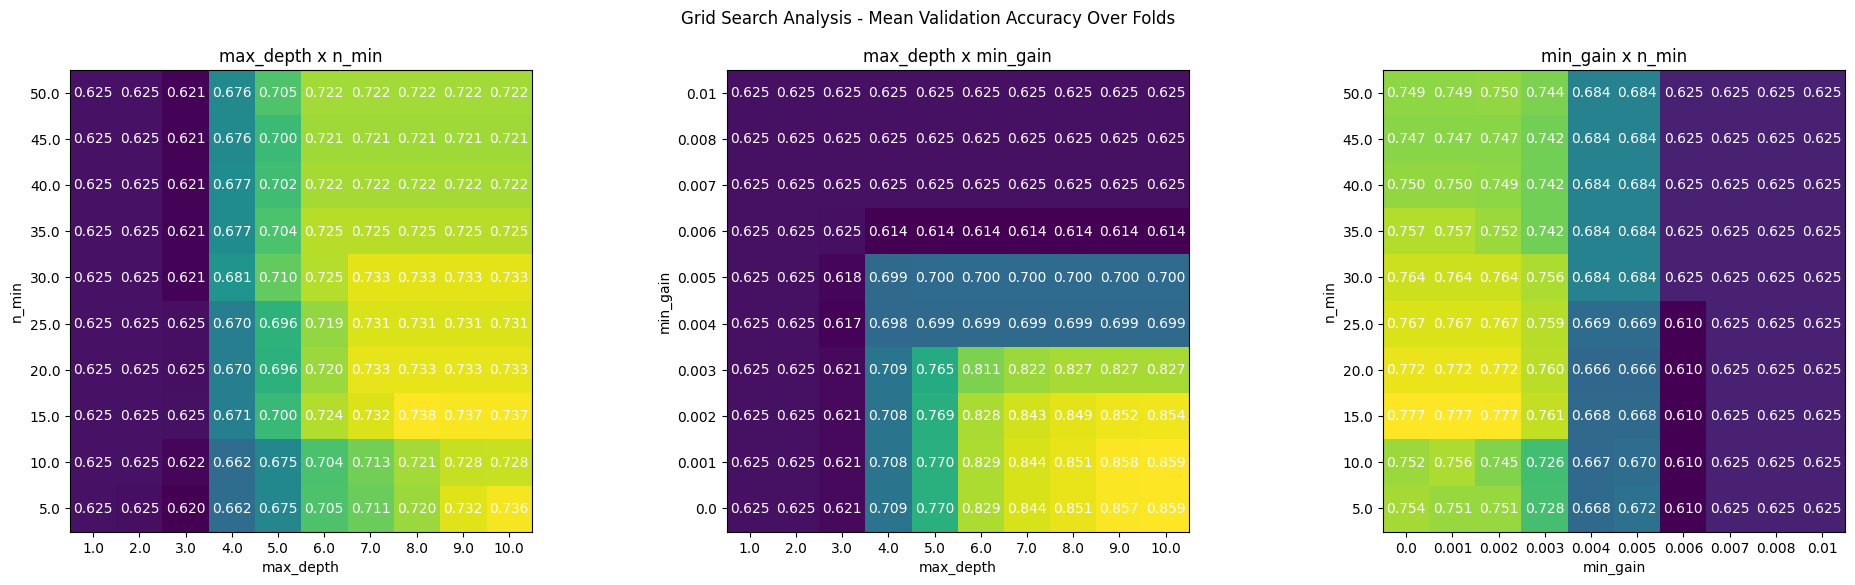

In [14]:
# Extracting parameters
max_depths = grid_stack["max_depth"].unique()
max_depths.sort()
n_mins = grid_stack["n_min"].unique()
n_mins.sort()
min_gains = grid_stack["min_gain"].unique()
min_gains.sort()

# max_depth x n_min heat map
grid_heat_dn = np.zeros((len(max_depths), len(n_mins)))
for i in range(len(max_depths)):
    for j in range(len(n_mins)):
        mask = (grid_stack["max_depth"] == max_depths[i]) & (
            grid_stack["n_min"] == n_mins[j]
        )
        grid_heat_dn[i][j] = np.mean(grid_stack[mask]["acc"])
grid_heat_dn = grid_heat_dn.T

# max_depth x min_gain heat map
grid_heat_dg = np.zeros((len(max_depths), len(min_gains)))
for i in range(len(max_depths)):
    for j in range(len(min_gains)):
        mask = (grid_stack["max_depth"] == max_depths[i]) & (
            grid_stack["min_gain"] == min_gains[j]
        )
        grid_heat_dg[i][j] = np.mean(grid_stack[mask]["acc"])
grid_heat_dg = grid_heat_dg.T

# min_gains x n_min heat map
grid_heat_gn = np.zeros((len(min_gains), len(n_mins)))
for i in range(len(min_gains)):
    for j in range(len(n_mins)):
        mask = (grid_stack["min_gain"] == min_gains[i]) & (
            grid_stack["n_min"] == n_mins[j]
        )
        grid_heat_gn[i][j] = np.mean(grid_stack[mask]["acc"])
grid_heat_gn = grid_heat_gn.T

# Plotting
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle("Grid Search Analysis - Mean Validation Accuracy Over Folds")

# max_depth x n_min
im = ax[0].imshow(grid_heat_dn, origin="lower")
ax[0].set_xticks(range(len(max_depths)), labels=max_depths)
ax[0].set_yticks(range(len(n_mins)), labels=n_mins)
for i in range(len(max_depths)):
    for j in range(len(n_mins)):
        text = ax[0].text(
            j, i, str(grid_heat_dn[i, j])[:5], ha="center", va="center", color="w"
        )
ax[0].set_title("max_depth x n_min")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_min")

# max_depth x min_gain
im = ax[1].imshow(grid_heat_dg, origin="lower")
ax[1].set_xticks(range(len(max_depths)), labels=max_depths)
ax[1].set_yticks(range(len(min_gains)), labels=[str(aux)[:5] for aux in min_gains])
for i in range(len(max_depths)):
    for j in range(len(min_gains)):
        text = ax[1].text(
            j, i, str(grid_heat_dg[i, j])[:5], ha="center", va="center", color="w"
        )
ax[1].set_title("max_depth x min_gain")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("min_gain")

# min_gain x n_min
im = ax[2].imshow(grid_heat_gn, origin="lower")
ax[2].set_xticks(range(len(min_gains)), labels=[str(aux)[:5] for aux in min_gains])
ax[2].set_yticks(range(len(n_mins)), labels=n_mins)
for i in range(len(min_gains)):
    for j in range(len(n_mins)):
        text = ax[2].text(
            j, i, str(grid_heat_gn[i, j])[:5], ha="center", va="center", color="w"
        )
ax[2].set_title("min_gain x n_min")
ax[2].set_xlabel("min_gain")
ax[2].set_ylabel("n_min")

# Showing figure
plt.show()
plt.close()

*No gráfico acima, quanto mais amarela a célula, maior é o seu valor (o valor da acurácia da respectiva combinação de hiperparâmetros).

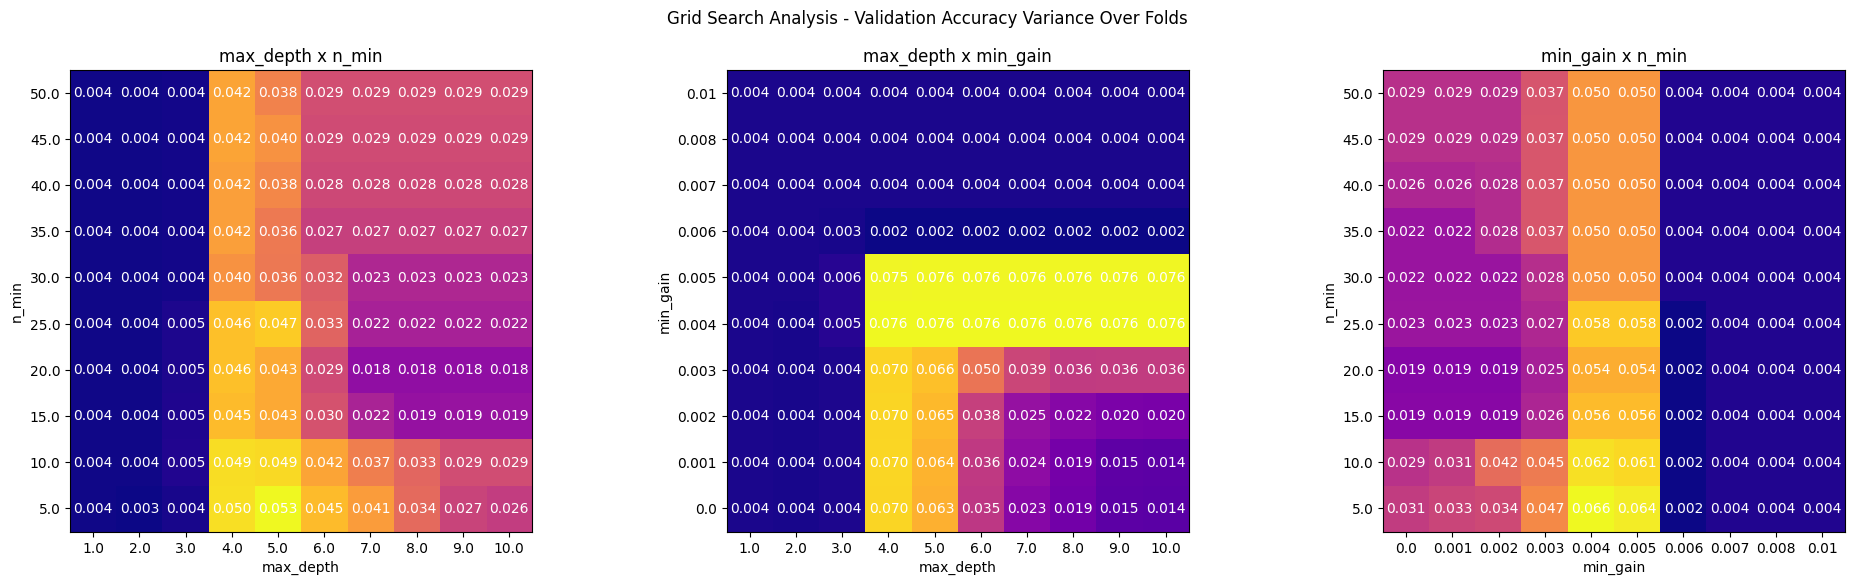

In [15]:
# Extracting parameters
max_depths = grid_stack["max_depth"].unique()
max_depths.sort()
n_mins = grid_stack["n_min"].unique()
n_mins.sort()
min_gains = grid_stack["min_gain"].unique()
min_gains.sort()

# max_depth x n_min heat map
grid_heat_dn = np.zeros((len(max_depths), len(n_mins)))
for i in range(len(max_depths)):
    for j in range(len(n_mins)):
        mask = (grid_stack["max_depth"] == max_depths[i]) & (
            grid_stack["n_min"] == n_mins[j]
        )
        grid_heat_dn[i][j] = np.mean(grid_stack[mask]["var_acc"])
grid_heat_dn = grid_heat_dn.T

# max_depth x min_gain heat map
grid_heat_dg = np.zeros((len(max_depths), len(min_gains)))
for i in range(len(max_depths)):
    for j in range(len(min_gains)):
        mask = (grid_stack["max_depth"] == max_depths[i]) & (
            grid_stack["min_gain"] == min_gains[j]
        )
        grid_heat_dg[i][j] = np.mean(grid_stack[mask]["var_acc"])
grid_heat_dg = grid_heat_dg.T

# min_gains x n_min heat map
grid_heat_gn = np.zeros((len(min_gains), len(n_mins)))
for i in range(len(min_gains)):
    for j in range(len(n_mins)):
        mask = (grid_stack["min_gain"] == min_gains[i]) & (
            grid_stack["n_min"] == n_mins[j]
        )
        grid_heat_gn[i][j] = np.mean(grid_stack[mask]["var_acc"])
grid_heat_gn = grid_heat_gn.T

# Plotting
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle("Grid Search Analysis - Validation Accuracy Variance Over Folds")

# max_depth x n_min
im = ax[0].imshow(grid_heat_dn, origin="lower", cmap="plasma")
ax[0].set_xticks(range(len(max_depths)), labels=max_depths)
ax[0].set_yticks(range(len(n_mins)), labels=n_mins)
for i in range(len(max_depths)):
    for j in range(len(n_mins)):
        text = ax[0].text(
            j, i, str(grid_heat_dn[i, j])[:5], ha="center", va="center", color="w"
        )
ax[0].set_title("max_depth x n_min")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_min")

# max_depth x min_gain
im = ax[1].imshow(grid_heat_dg, origin="lower", cmap="plasma")
ax[1].set_xticks(range(len(max_depths)), labels=max_depths)
ax[1].set_yticks(range(len(min_gains)), labels=[str(aux)[:5] for aux in min_gains])
for i in range(len(max_depths)):
    for j in range(len(min_gains)):
        text = ax[1].text(
            j, i, str(grid_heat_dg[i, j])[:5], ha="center", va="center", color="w"
        )
ax[1].set_title("max_depth x min_gain")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("min_gain")

# min_gain x n_min
im = ax[2].imshow(grid_heat_gn, origin="lower", cmap="plasma")
ax[2].set_xticks(range(len(min_gains)), labels=[str(aux)[:5] for aux in min_gains])
ax[2].set_yticks(range(len(n_mins)), labels=n_mins)
for i in range(len(min_gains)):
    for j in range(len(n_mins)):
        text = ax[2].text(
            j, i, str(grid_heat_gn[i, j])[:5], ha="center", va="center", color="w"
        )
ax[2].set_title("min_gain x n_min")
ax[2].set_xlabel("min_gain")
ax[2].set_ylabel("n_min")

# Showing figure
plt.show()
plt.close()

*No gráfico acima, quanto mais amarela a célula, maior é o seu valor (o valor da variância acurácia da respectiva combinação de hiperparâmetros entre folds).

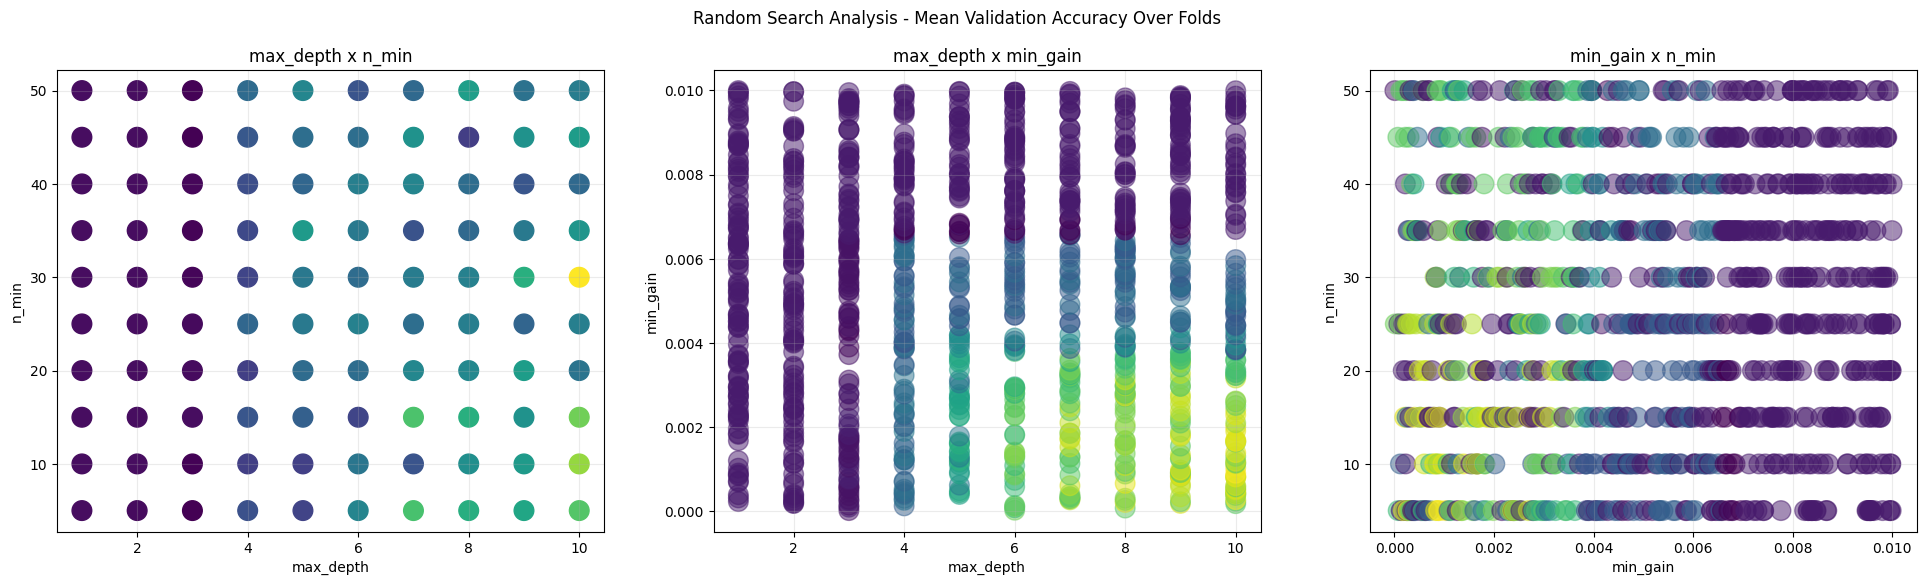

In [16]:
# Extracting parameters
max_depths = random_stack["max_depth"].unique()
max_depths.sort()
n_mins = random_stack["n_min"].unique()
n_mins.sort()
min_gains = random_stack["min_gain"].unique()
min_gains.sort()

# max_depth x n_min heat map
random_heat_dn = np.zeros((3, len(max_depths) * len(n_mins)))
for i in range(len(max_depths)):
    for j in range(len(n_mins)):
        random_heat_dn[0][i * len(n_mins) + j] = max_depths[i]
        random_heat_dn[1][i * len(n_mins) + j] = n_mins[j]
        mask = (random_stack["max_depth"] == max_depths[i]) & (
            random_stack["n_min"] == n_mins[j]
        )
        random_heat_dn[2][i * len(n_mins) + j] = np.mean(random_stack[mask]["acc"])

# max_depth x min_gain heat map
random_heat_dg = np.zeros((3, len(max_depths) * len(min_gains)))
for i in range(len(max_depths)):
    for j in range(len(min_gains)):
        random_heat_dg[0][i * len(min_gains) + j] = max_depths[i]
        random_heat_dg[1][i * len(min_gains) + j] = min_gains[j]
        mask = (random_stack["max_depth"] == max_depths[i]) & (
            random_stack["min_gain"] == min_gains[j]
        )
        random_heat_dg[2][i * len(min_gains) + j] = np.mean(random_stack[mask]["acc"])

# min_gains x n_min heat map
random_heat_gn = np.zeros((3, len(min_gains) * len(n_mins)))
random_heat_gn.shape
for i in range(len(min_gains)):
    for j in range(len(n_mins)):
        random_heat_gn[0][i * len(n_mins) + j] = min_gains[i]
        random_heat_gn[1][i * len(n_mins) + j] = n_mins[j]
        mask = (random_stack["min_gain"] == min_gains[i]) & (
            random_stack["n_min"] == n_mins[j]
        )
        random_heat_gn[2][i * len(n_mins) + j] = np.mean(random_stack[mask]["acc"])

# Plotting
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle("Random Search Analysis - Mean Validation Accuracy Over Folds")

# max_depth x n_min
ax[0].scatter(x=random_heat_dn[0], y=random_heat_dn[1], s=200, c=random_heat_dn[2])
ax[0].set_title("max_depth x n_min")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_min")

# max_depth x min_gain
ax[1].scatter(
    x=random_heat_dg[0], y=random_heat_dg[1], s=200, c=random_heat_dg[2], alpha=0.5
)
ax[1].set_title("max_depth x min_gain")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("min_gain")

# min_gain x n_min
ax[2].scatter(
    x=random_heat_gn[0], y=random_heat_gn[1], s=200, c=random_heat_gn[2], alpha=0.5
)
ax[2].set_title("min_gain x n_min")
ax[2].set_xlabel("min_gain")
ax[2].set_ylabel("n_min")

# Showing figure
[x.grid(alpha=0.25) for x in ax]
plt.show()
plt.close()

*No gráfico acima, quanto mais amarela a célula, maior é o seu valor (o valor da acurácia da respectiva combinação de hiperparâmetros).

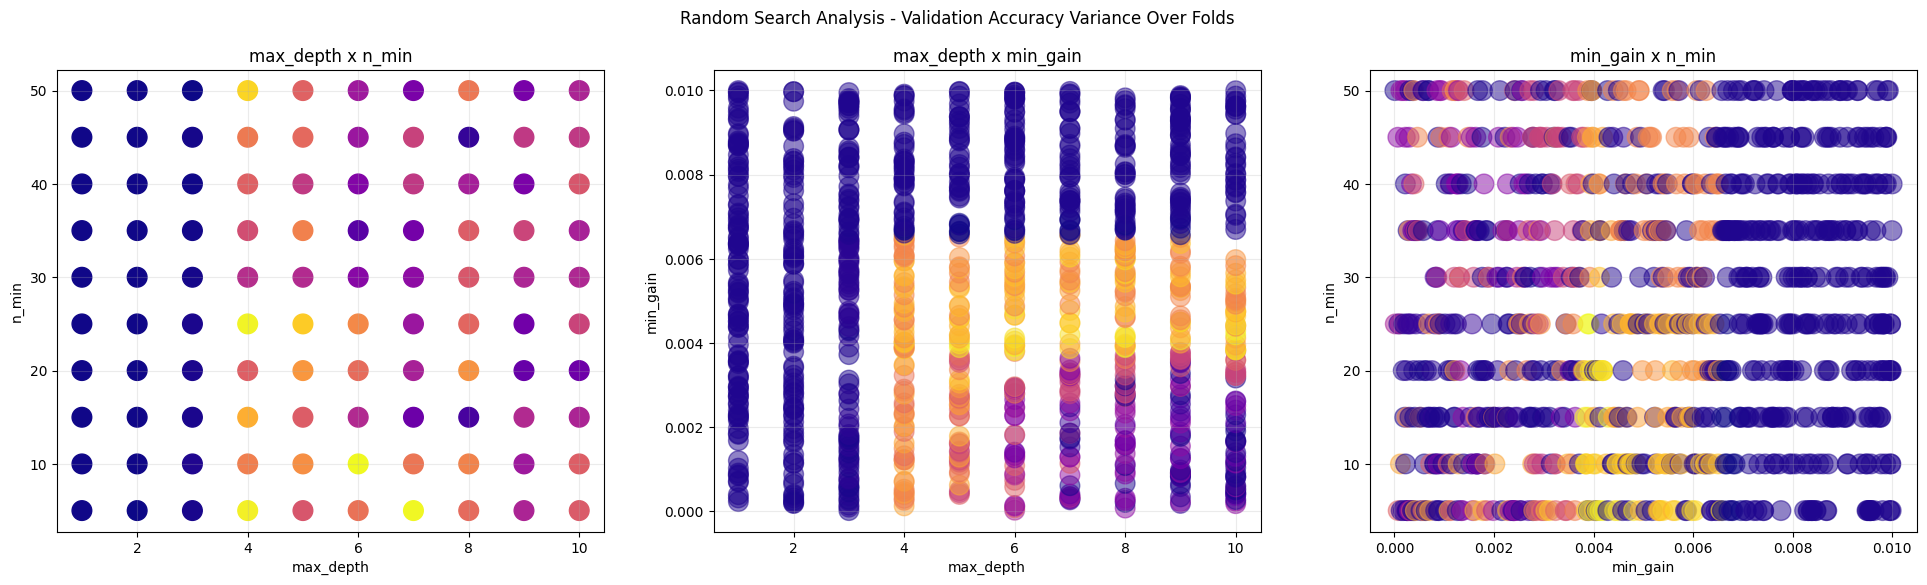

In [17]:
# Extracting parameters
max_depths = random_stack["max_depth"].unique()
max_depths.sort()
n_mins = random_stack["n_min"].unique()
n_mins.sort()
min_gains = random_stack["min_gain"].unique()
min_gains.sort()

# max_depth x n_min heat map
random_heat_dn = np.zeros((3, len(max_depths) * len(n_mins)))
for i in range(len(max_depths)):
    for j in range(len(n_mins)):
        random_heat_dn[0][i * len(n_mins) + j] = max_depths[i]
        random_heat_dn[1][i * len(n_mins) + j] = n_mins[j]
        mask = (random_stack["max_depth"] == max_depths[i]) & (
            random_stack["n_min"] == n_mins[j]
        )
        random_heat_dn[2][i * len(n_mins) + j] = np.mean(random_stack[mask]["var_acc"])

# max_depth x min_gain heat map
random_heat_dg = np.zeros((3, len(max_depths) * len(min_gains)))
for i in range(len(max_depths)):
    for j in range(len(min_gains)):
        random_heat_dg[0][i * len(min_gains) + j] = max_depths[i]
        random_heat_dg[1][i * len(min_gains) + j] = min_gains[j]
        mask = (random_stack["max_depth"] == max_depths[i]) & (
            random_stack["min_gain"] == min_gains[j]
        )
        random_heat_dg[2][i * len(min_gains) + j] = np.mean(random_stack[mask]["var_acc"])

# min_gains x n_min heat map
random_heat_gn = np.zeros((3, len(min_gains) * len(n_mins)))
random_heat_gn.shape
for i in range(len(min_gains)):
    for j in range(len(n_mins)):
        random_heat_gn[0][i * len(n_mins) + j] = min_gains[i]
        random_heat_gn[1][i * len(n_mins) + j] = n_mins[j]
        mask = (random_stack["min_gain"] == min_gains[i]) & (
            random_stack["n_min"] == n_mins[j]
        )
        random_heat_gn[2][i * len(n_mins) + j] = np.mean(random_stack[mask]["var_acc"])

# Plotting
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle("Random Search Analysis - Validation Accuracy Variance Over Folds")

# max_depth x n_min
ax[0].scatter(x=random_heat_dn[0], y=random_heat_dn[1], s=200, c=random_heat_dn[2], cmap="plasma")
ax[0].set_title("max_depth x n_min")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_min")

# max_depth x min_gain
ax[1].scatter(
    x=random_heat_dg[0], y=random_heat_dg[1], s=200, c=random_heat_dg[2], alpha=0.5, cmap="plasma"
)
ax[1].set_title("max_depth x min_gain")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("min_gain")

# min_gain x n_min
ax[2].scatter(
    x=random_heat_gn[0], y=random_heat_gn[1], s=200, c=random_heat_gn[2], alpha=0.5, cmap="plasma"
)
ax[2].set_title("min_gain x n_min")
ax[2].set_xlabel("min_gain")
ax[2].set_ylabel("n_min")

# Showing figure
[x.grid(alpha=0.25) for x in ax]
plt.show()
plt.close()

*No gráfico acima, quanto mais amarela a célula, maior é o seu valor (o valor da variância acurácia da respectiva combinação de hiperparâmetros entre folds).

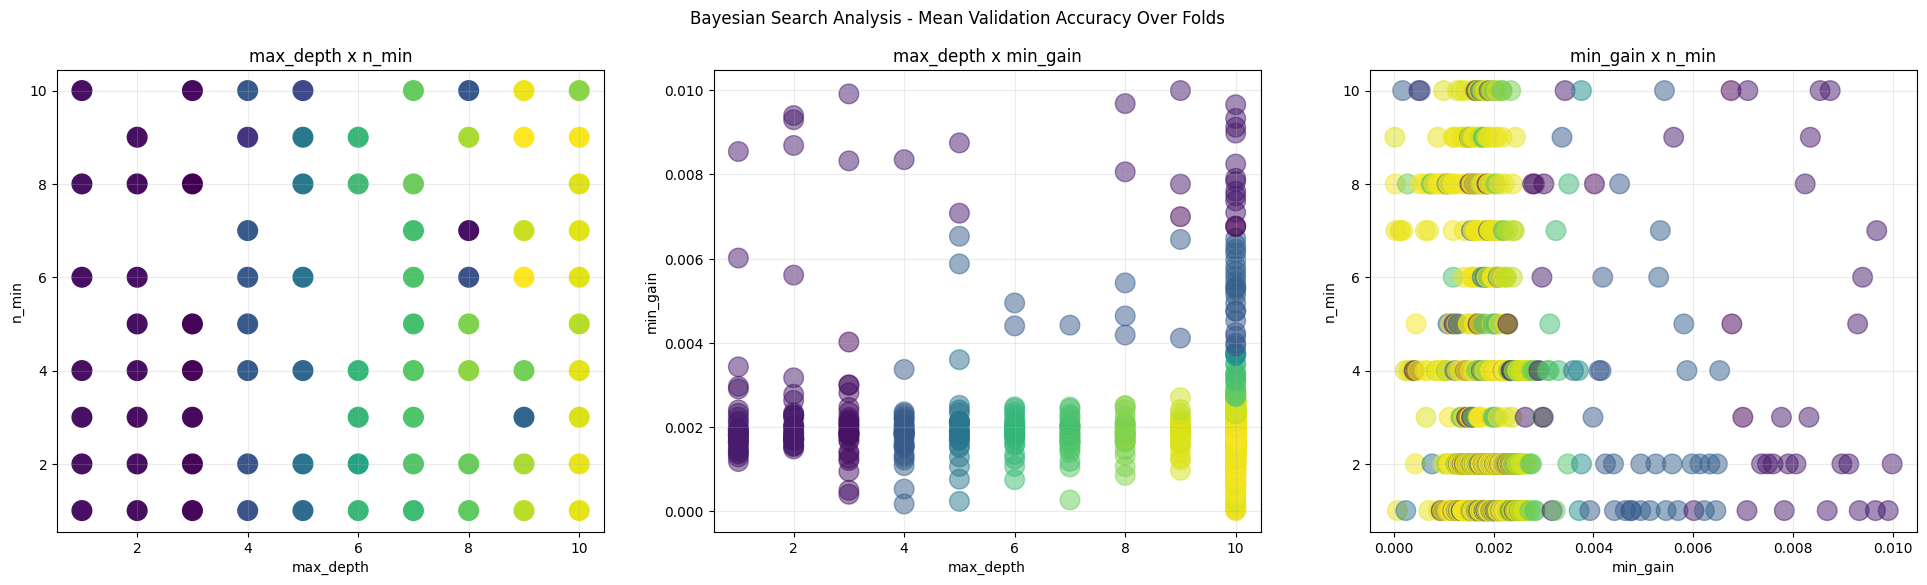

In [18]:
# Extracting parameters
max_depths = bayes_stack["max_depth"].unique()
max_depths.sort()
n_mins = bayes_stack["n_min"].unique()
n_mins.sort()
min_gains = bayes_stack["min_gain"].unique()
min_gains.sort()

# max_depth x n_min heat map
bayes_heat_dn = np.zeros((3, len(max_depths) * len(n_mins)))
for i in range(len(max_depths)):
    for j in range(len(n_mins)):
        bayes_heat_dn[0][i * len(n_mins) + j] = max_depths[i]
        bayes_heat_dn[1][i * len(n_mins) + j] = n_mins[j]
        mask = (bayes_stack["max_depth"] == max_depths[i]) & (
            bayes_stack["n_min"] == n_mins[j]
        )
        bayes_heat_dn[2][i * len(n_mins) + j] = np.mean(bayes_stack[mask]["acc"])

# max_depth x min_gain heat map
bayes_heat_dg = np.zeros((3, len(max_depths) * len(min_gains)))
for i in range(len(max_depths)):
    for j in range(len(min_gains)):
        bayes_heat_dg[0][i * len(min_gains) + j] = max_depths[i]
        bayes_heat_dg[1][i * len(min_gains) + j] = min_gains[j]
        mask = (bayes_stack["max_depth"] == max_depths[i]) & (
            bayes_stack["min_gain"] == min_gains[j]
        )
        bayes_heat_dg[2][i * len(min_gains) + j] = np.mean(bayes_stack[mask]["acc"])

# min_gains x n_min heat map
bayes_heat_gn = np.zeros((3, len(min_gains) * len(n_mins)))
bayes_heat_gn.shape
for i in range(len(min_gains)):
    for j in range(len(n_mins)):
        bayes_heat_gn[0][i * len(n_mins) + j] = min_gains[i]
        bayes_heat_gn[1][i * len(n_mins) + j] = n_mins[j]
        mask = (bayes_stack["min_gain"] == min_gains[i]) & (
            bayes_stack["n_min"] == n_mins[j]
        )
        bayes_heat_gn[2][i * len(n_mins) + j] = np.mean(bayes_stack[mask]["acc"])

# Plotting
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle("Bayesian Search Analysis - Mean Validation Accuracy Over Folds")

# max_depth x n_min
ax[0].scatter(x=bayes_heat_dn[0], y=bayes_heat_dn[1], s=200, c=bayes_heat_dn[2])
ax[0].set_title("max_depth x n_min")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_min")

# max_depth x min_gain
ax[1].scatter(
    x=bayes_heat_dg[0], y=bayes_heat_dg[1], s=200, c=bayes_heat_dg[2], alpha=0.5
)
ax[1].set_title("max_depth x min_gain")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("min_gain")

# min_gain x n_min
ax[2].scatter(
    x=bayes_heat_gn[0], y=bayes_heat_gn[1], s=200, c=bayes_heat_gn[2], alpha=0.5
)
ax[2].set_title("min_gain x n_min")
ax[2].set_xlabel("min_gain")
ax[2].set_ylabel("n_min")

# Showing figure
[x.grid(alpha=0.25) for x in ax]
plt.show()
plt.close()

*No gráfico acima, quanto mais amarela a célula, maior é o seu valor (o valor da acurácia da respectiva combinação de hiperparâmetros).

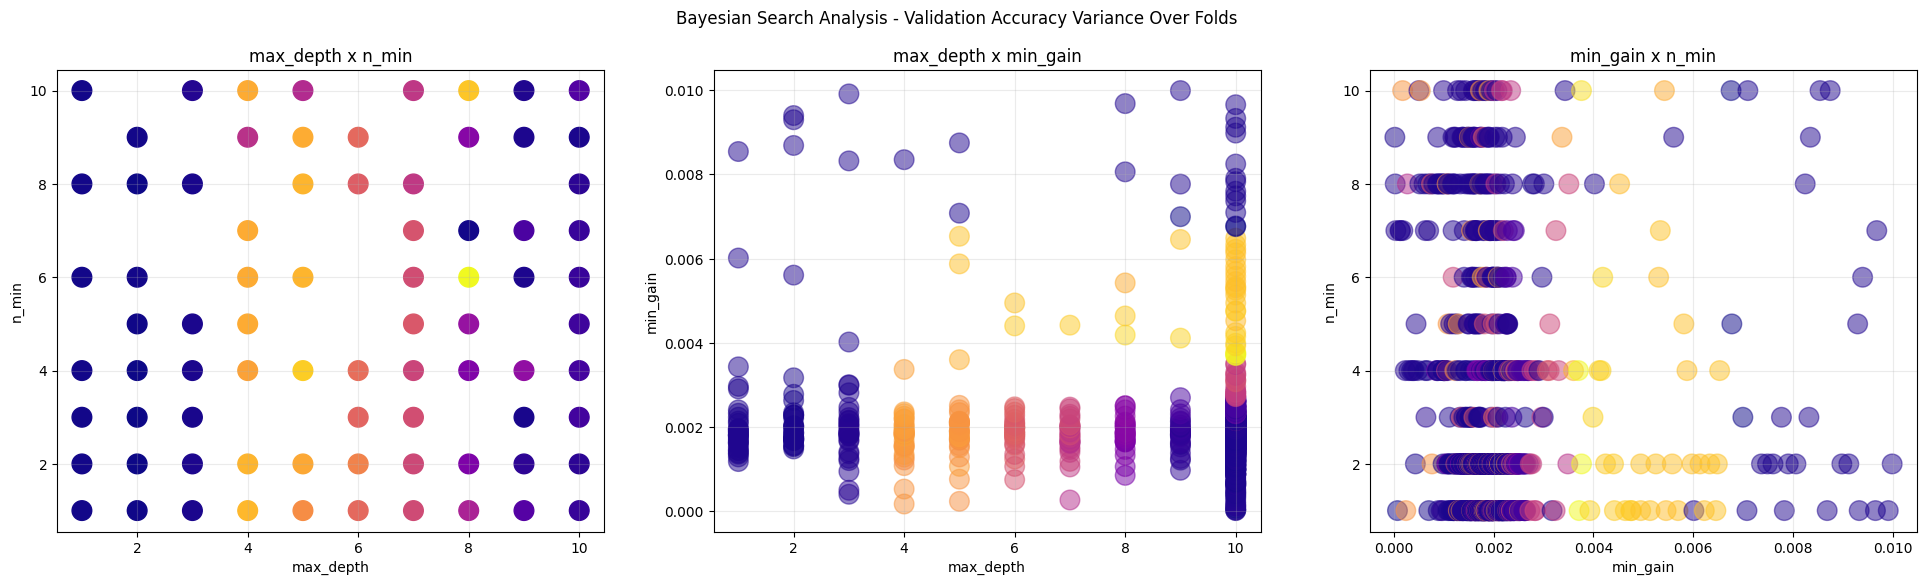

In [19]:
# Extracting parameters
max_depths = bayes_stack["max_depth"].unique()
max_depths.sort()
n_mins = bayes_stack["n_min"].unique()
n_mins.sort()
min_gains = bayes_stack["min_gain"].unique()
min_gains.sort()

# max_depth x n_min heat map
bayes_heat_dn = np.zeros((3, len(max_depths) * len(n_mins)))
for i in range(len(max_depths)):
    for j in range(len(n_mins)):
        bayes_heat_dn[0][i * len(n_mins) + j] = max_depths[i]
        bayes_heat_dn[1][i * len(n_mins) + j] = n_mins[j]
        mask = (bayes_stack["max_depth"] == max_depths[i]) & (
            bayes_stack["n_min"] == n_mins[j]
        )
        bayes_heat_dn[2][i * len(n_mins) + j] = np.mean(bayes_stack[mask]["var_acc"])

# max_depth x min_gain heat map
bayes_heat_dg = np.zeros((3, len(max_depths) * len(min_gains)))
for i in range(len(max_depths)):
    for j in range(len(min_gains)):
        bayes_heat_dg[0][i * len(min_gains) + j] = max_depths[i]
        bayes_heat_dg[1][i * len(min_gains) + j] = min_gains[j]
        mask = (bayes_stack["max_depth"] == max_depths[i]) & (
            bayes_stack["min_gain"] == min_gains[j]
        )
        bayes_heat_dg[2][i * len(min_gains) + j] = np.mean(bayes_stack[mask]["var_acc"])

# min_gains x n_min heat map
bayes_heat_gn = np.zeros((3, len(min_gains) * len(n_mins)))
bayes_heat_gn.shape
for i in range(len(min_gains)):
    for j in range(len(n_mins)):
        bayes_heat_gn[0][i * len(n_mins) + j] = min_gains[i]
        bayes_heat_gn[1][i * len(n_mins) + j] = n_mins[j]
        mask = (bayes_stack["min_gain"] == min_gains[i]) & (
            bayes_stack["n_min"] == n_mins[j]
        )
        bayes_heat_gn[2][i * len(n_mins) + j] = np.mean(bayes_stack[mask]["var_acc"])

# Plotting
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle("Bayesian Search Analysis - Validation Accuracy Variance Over Folds")

# max_depth x n_min
ax[0].scatter(x=bayes_heat_dn[0], y=bayes_heat_dn[1], s=200, c=bayes_heat_dn[2], cmap="plasma")
ax[0].set_title("max_depth x n_min")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_min")

# max_depth x min_gain
ax[1].scatter(
    x=bayes_heat_dg[0], y=bayes_heat_dg[1], s=200, c=bayes_heat_dg[2], alpha=0.5, cmap="plasma"
)
ax[1].set_title("max_depth x min_gain")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("min_gain")

# min_gain x n_min
ax[2].scatter(
    x=bayes_heat_gn[0], y=bayes_heat_gn[1], s=200, c=bayes_heat_gn[2], alpha=0.5, cmap="plasma"
)
ax[2].set_title("min_gain x n_min")
ax[2].set_xlabel("min_gain")
ax[2].set_ylabel("n_min")

# Showing figure
[x.grid(alpha=0.25) for x in ax]
plt.show()
plt.close()

*No gráfico acima, quanto mais amarela a célula, maior é o seu valor (o valor da variância acurácia da respectiva combinação de hiperparâmetros entre folds).

##### Resultados

In [20]:
# Final tree optimized via grid
tree = DecisionTreeClassifier(
    criterion="gini",
    random_state=RANDOM_STATE,
    max_depth=grid_best[0],
    min_samples_leaf=grid_best[1],
    min_impurity_decrease=grid_best[2],
)
tree.fit(X_train, y_train)

# Accuracy
predictions = tree.predict(X_test)
print("Accuracy:", sum(predictions == y_test) / y_test.shape[0])

# Confusion matrix
true_0 = test["y"] == 0
true_1 = test["y"] == 1

true_negative = sum(predictions[true_0] == 0)
false_negative = sum(predictions[true_1] == 0)

true_positive = sum(predictions[true_1] == 1)
false_positive = sum(predictions[true_0] == 1)

confusion_matrix = {
    "Predicted 0": [true_negative, false_negative, true_negative + false_negative],
    "Predicted 1": [false_positive, true_positive, false_positive + true_positive],
    "Total": [
        true_negative + false_positive,
        false_negative + true_positive,
        true_negative + false_negative + false_positive + true_positive,
    ],
}
confusion_matrix = pd.DataFrame.from_dict(
    confusion_matrix, orient="index", columns=["True 0", "True 1", "Total"]
)
display(confusion_matrix)

Accuracy: 0.8691796008869179


,True 0,True 1,Total
Predicted 0,188,22,210
Predicted 1,37,204,241
Total,225,226,451


In [21]:
# Final tree optimized via grid
tree = DecisionTreeClassifier(
    criterion="gini",
    random_state=RANDOM_STATE,
    max_depth=random_best[0],
    min_samples_leaf=random_best[1],
    min_impurity_decrease=random_best[2],
)
tree.fit(X_train, y_train)

# Accuracy
predictions = tree.predict(X_test)
print("Accuracy:", sum(predictions == y_test) / y_test.shape[0])

# Confusion matrix
true_0 = test["y"] == 0
true_1 = test["y"] == 1

true_negative = sum(predictions[true_0] == 0)
false_negative = sum(predictions[true_1] == 0)

true_positive = sum(predictions[true_1] == 1)
false_positive = sum(predictions[true_0] == 1)

confusion_matrix = {
    "Predicted 0": [true_negative, false_negative, true_negative + false_negative],
    "Predicted 1": [false_positive, true_positive, false_positive + true_positive],
    "Total": [
        true_negative + false_positive,
        false_negative + true_positive,
        true_negative + false_negative + false_positive + true_positive,
    ],
}
confusion_matrix = pd.DataFrame.from_dict(
    confusion_matrix, orient="index", columns=["True 0", "True 1", "Total"]
)
display(confusion_matrix)

Accuracy: 0.8802660753880266


,True 0,True 1,Total
Predicted 0,190,19,209
Predicted 1,35,207,242
Total,225,226,451


In [22]:
# Final tree optimized via grid
tree = DecisionTreeClassifier(
    criterion="gini",
    random_state=RANDOM_STATE,
    max_depth=bayes_best[0],
    min_samples_leaf=bayes_best[1],
    min_impurity_decrease=bayes_best[2],
)
tree.fit(X_train, y_train)

# Accuracy
predictions = tree.predict(X_test)
print("Accuracy:", sum(predictions == y_test) / y_test.shape[0])

# Confusion matrix
true_0 = test["y"] == 0
true_1 = test["y"] == 1

true_negative = sum(predictions[true_0] == 0)
false_negative = sum(predictions[true_1] == 0)

true_positive = sum(predictions[true_1] == 1)
false_positive = sum(predictions[true_0] == 1)

confusion_matrix = {
    "Predicted 0": [true_negative, false_negative, true_negative + false_negative],
    "Predicted 1": [false_positive, true_positive, false_positive + true_positive],
    "Total": [
        true_negative + false_positive,
        false_negative + true_positive,
        true_negative + false_negative + false_positive + true_positive,
    ],
}
confusion_matrix = pd.DataFrame.from_dict(
    confusion_matrix, orient="index", columns=["True 0", "True 1", "Total"]
)
display(confusion_matrix)

Accuracy: 0.917960088691796


,True 0,True 1,Total
Predicted 0,196,8,204
Predicted 1,29,218,247
Total,225,226,451


##### Discussão

*Feito à mão e anexado ao .pdf*